# Model fitting with `cluster-lensing` & `emcee`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import emcee
import corner

from clusterlensing import ClusterEnsemble

% matplotlib inline

In [2]:
from astrolabels import AstroLabels
alab = AstroLabels()

## Generate a noisy measurement to fit

In [3]:
# make up some data
n_clusters = 1
nbins = 10

logm_true = 14
off_true = 0.3

redshifts = [0.2] * n_clusters
mass = [10**logm_true] * n_clusters
offsets = [off_true] * n_clusters
rbins = np.logspace(np.log10(0.1), np.log10(5), num = nbins)

cdata = ClusterEnsemble(redshifts)
cdata.m200 = mass
cdata.calc_nfw(rbins=rbins, offsets=offsets)

#cdata.deltasigma_nfw.mean(axis=0)
dsig_data = cdata.deltasigma_nfw.mean(axis=0).value

In [4]:
# scatter with a stddev of % of data or max(data)?
frac_err = 0.2
noise = np.random.normal(scale=dsig_data*frac_err, size=nbins)
y = dsig_data + noise

# 33% error bars
yerr = np.abs(dsig_data/3)

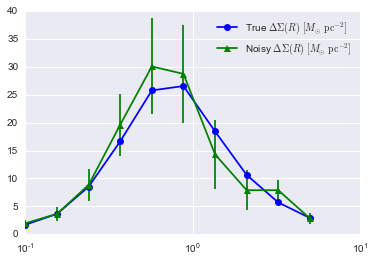

In [5]:
plt.plot(rbins, dsig_data, 'bo-', label='True '+alab.dsigma)
plt.plot(rbins, y, 'g^-', label='Noisy '+alab.dsigma)
plt.errorbar(rbins, y, yerr=yerr, color='g', linestyle='None')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

## Write down likelihood, prior, and posterior probilities
The model parameters are the mass and centroid offsets. Redshift is assumed to be known.

In [6]:
# prob of data given a model
def lnlike(theta, z, rbins, data, stddev):
    logm, offsets = theta
    
    # calculate the model
    c = ClusterEnsemble(z)
    c.m200 = [10 ** logm]
    c.calc_nfw(rbins=rbins, offsets=[offsets])
    model = c.deltasigma_nfw.mean(axis=0).value
    
    diff = data - model
    lnlikelihood = -0.5 * np.sum(diff**2 / stddev**2)
    return lnlikelihood

# uninformative prior
def lnprior(theta):
    logm, offset = theta
    if 10 < logm < 16 and 0.0 <= offset < 5.0:
        return 0.0
    return -np.inf

# posterior
def lnprob(theta, z, rbins, data, stddev):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, z, rbins, data, stddev)

### Sample the posterior using `emcee`

In [39]:
ndim = 2
nwalkers = 20
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
p0[:,0] = p0[:,0] + 14  # start somewhere close to true logm ~ 14

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(redshifts, rbins, y, yerr), threads=8)

In [40]:
#%timeit -n 1 -r 1 
pos, prob, state = sampler.run_mcmc(p0, 10)
#sampler.reset()

In [45]:
# repeat as necessary, or increase number of steps
#%timeit -n 1 -r 1 
pos, prob, state = sampler.run_mcmc(pos, 400)

### Check walker positions for burn-in

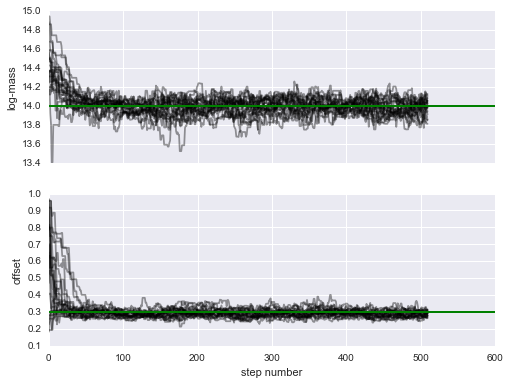

In [46]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].axhline(logm_true, color="g", lw=2)
axes[0].set_ylabel("log-mass")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].axhline(off_true, color="g", lw=2)
axes[1].set_ylabel("offset")
axes[1].set_xlabel("step number")

plt.savefig('walkers.png')

In [47]:
# according to the docs, this should be between 0.25 and 0.5...
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.684


## Model parameter results

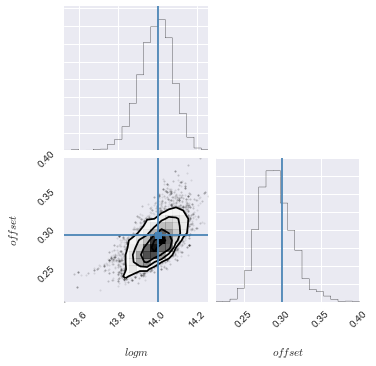

In [48]:
burn_in_step = 80
samples = sampler.chain[:,burn_in_step:,:].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$logm$", "$offset$"], truths=[logm_true, off_true])
plt.savefig('cornerplot.png')

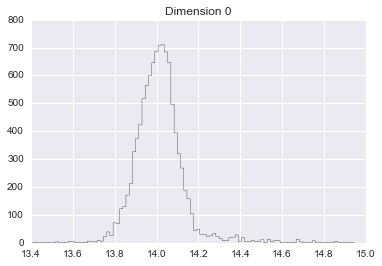

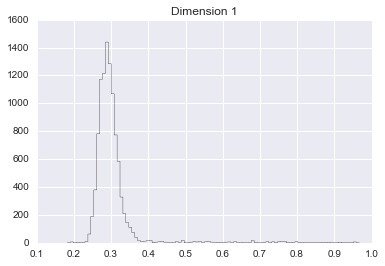

In [49]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

plt.show()